# Northwind Data Analysis

## Description:
In this project, I aim to perform some exploratory data analysis as well as sample business questions that could be answered with the data

## Pre-Reqs
You will need to perform the following: <br>
<ul>
    <li>Install Microsoft SQL Server Management Studio: <a href="https://learn.microsoft.com/en-us/sql/ssms/download-sql-server-management-studio-ssms?view=sql-server-ver16">https://learn.microsoft.com/en-us/sql/ssms/download-sql-server-management-studio-ssms?view=sql-server-ver16</a> </li>
    <li>Create the Northwind Database: <a href="https://github.com/Microsoft/sql-server-samples/tree/master/samples/databases/northwind-pubs">https://github.com/Microsoft/sql-server-samples/tree/master/samples/databases/northwind-pubs"</a></li>
</ul>

In [34]:
import os
import sys
sys.path.append(os.path.realpath('..'))
from sqlalchemy import create_engine, MetaData
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from pandasql import sqldf
from sqlalchemy_schemadisplay import create_schema_graph
from configuration.config import DB_HOST #you will need to create this. It is not recommended to store any server credentials in a Github repo

In [2]:
%matplotlib inline

In [3]:
northwind_engine = create_engine(f"mssql+pymssql://{DB_HOST}/Northwind")

## ERD
I like to create the ERD to display relationships amongst the tables

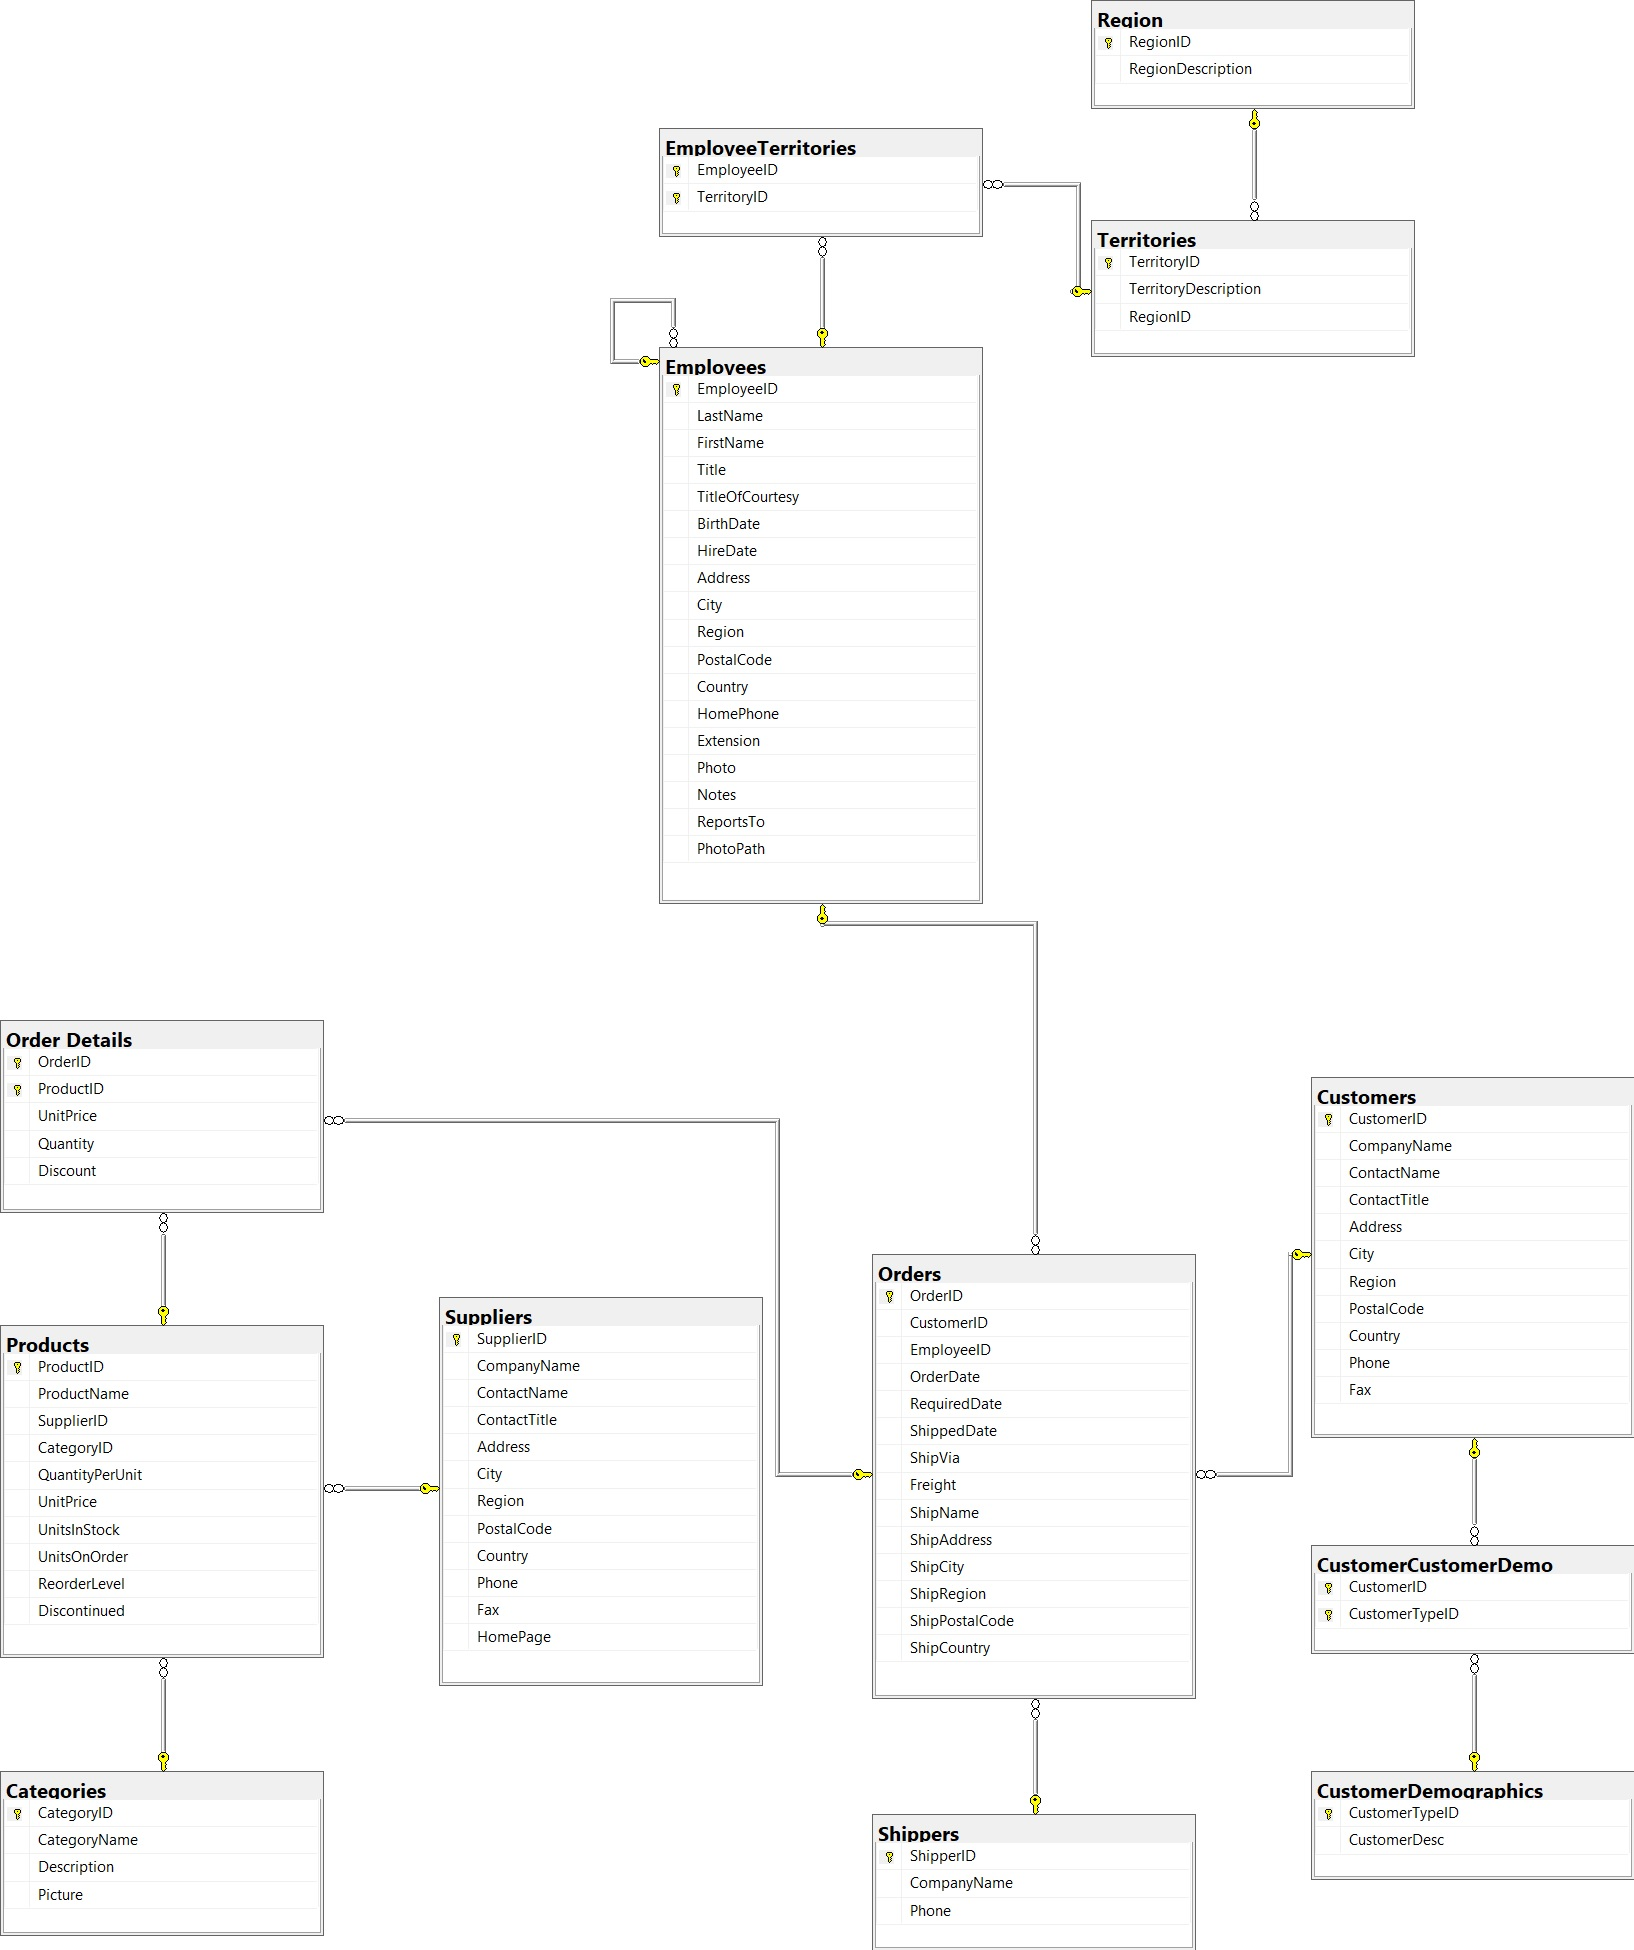

In [4]:
Image(filename= 'northwind_erd.jpg')

## Import all of this data

In [5]:
customers = pd.read_sql("SELECT * FROM Customers", con = northwind_engine)
orders = pd.read_sql("SELECT * FROM Orders", con = northwind_engine, parse_dates = ['OrderDate', 'RequiredDate', 'ShippedDate'])
order_details = pd.read_sql("SELECT * FROM [Order Details]", con = northwind_engine)
products = pd.read_sql("SELECT * FROM Products", con = northwind_engine)
categories= pd.read_sql("SELECT * FROM Categories", con = northwind_engine)
suppliers = pd.read_sql("SELECT * FROM Suppliers", con = northwind_engine)
shippers = pd.read_sql("SELECT * FROM Shippers", con = northwind_engine)
employees = pd.read_sql("SELECT * FROM Employees", con = northwind_engine)

# EDA

## How many employees do we have?

In [6]:
sqldf( 
    """
    SELECT COUNT(DISTINCT employeeid) as num_employees
    FROM employees
    """
)

,num_employees
0,9


Northwind is a very small company for sure!

## What are the categories of the products that Northwind sells?

In [7]:
sqldf(
    """SELECT DISTINCT
        categoryname
        FROM categories
    """
)

,CategoryName
0,Beverages
1,Condiments
2,Confections
3,Dairy Products
4,Grains/Cereals
5,Meat/Poultry
6,Produce
7,Seafood


## How many customers do we have?

In [8]:
customers[['CustomerID', 'ContactName']].drop_duplicates()

,CustomerID,ContactName
0,ALFKI,Maria Anders
1,ANATR,Ana Trujillo
2,ANTON,Antonio Moreno
3,AROUT,Thomas Hardy
4,BERGS,Christina Berglund
...,...,...
86,WARTH,Pirkko Koskitalo
87,WELLI,Paula Parente
88,WHITC,Karl Jablonski
89,WILMK,Matti Karttunen


Northwind has a fair number of customers

# Business Questions

## How many orders did Northwind have by year
Let me show you the pandas appraoch vs the sqldf approach for this

### pandas approach

In [9]:
orders.groupby(orders['OrderDate'].dt.year)['OrderID'].agg('count')

OrderDate
1996    152
1997    408
1998    270
Name: OrderID, dtype: int64

In [10]:
# could also use a pivot table as well if you like
orders['year'] = orders['OrderDate'].dt.year
pd.pivot_table(orders, index = 'year', values = 'OrderID', aggfunc='count')

,OrderID
year,
1996,152
1997,408
1998,270


In [11]:
# Drop this right after
orders.drop('year', axis = 1, inplace = True)

## sqldf approach

In [12]:
# https://www.sqlitetutorial.net/sqlite-date-functions/sqlite-strftime-function/
sqldf(
    """
    SELECT
        strftime('%Y', OrderDate) as yearorder,
        COUNT(OrderID) as num_orders
    FROM 
        orders
    GROUP BY
        1
    """)

,yearorder,num_orders
0,1996,152
1,1997,408
2,1998,270


It appears the majority of the orders were placed in 1997

## How many products by category did we sell?

In [13]:
sold_by_category_overall = sqldf("""
SELECT
    c.CategoryName,
    COUNT(od.ProductID) as items_sold
FROM
    order_details od
INNER JOIN products p
ON p.ProductID = od.ProductID
INNER JOIN categories c
ON c.CategoryID = p.CategoryID
GROUP BY
    c.CategoryName
"""
                                  )

In [14]:
sold_by_category_overall

,CategoryName,items_sold
0,Beverages,404
1,Condiments,216
2,Confections,334
3,Dairy Products,366
4,Grains/Cereals,196
5,Meat/Poultry,173
6,Produce,136
7,Seafood,330


## Based on the prior question, we would like to break this down further by year

In [15]:
products_sold_category_by_year = sqldf(
    """
    SELECT
        strftime('%Y', o.OrderDate) as year,
        c.categoryname,
        COUNT(od.productid) as num_sold
    FROM orders o
    INNER JOIN order_details as od
        ON od.orderid = o.orderid
    INNER JOIN products p 
        ON od.productid = p.productid
    INNER JOIN categories c
     ON c.categoryid = p.categoryid
    GROUP BY
        1,2
    """
)

<Axes: title={'center': 'Products Sold By Category By Year'}, xlabel='year'>

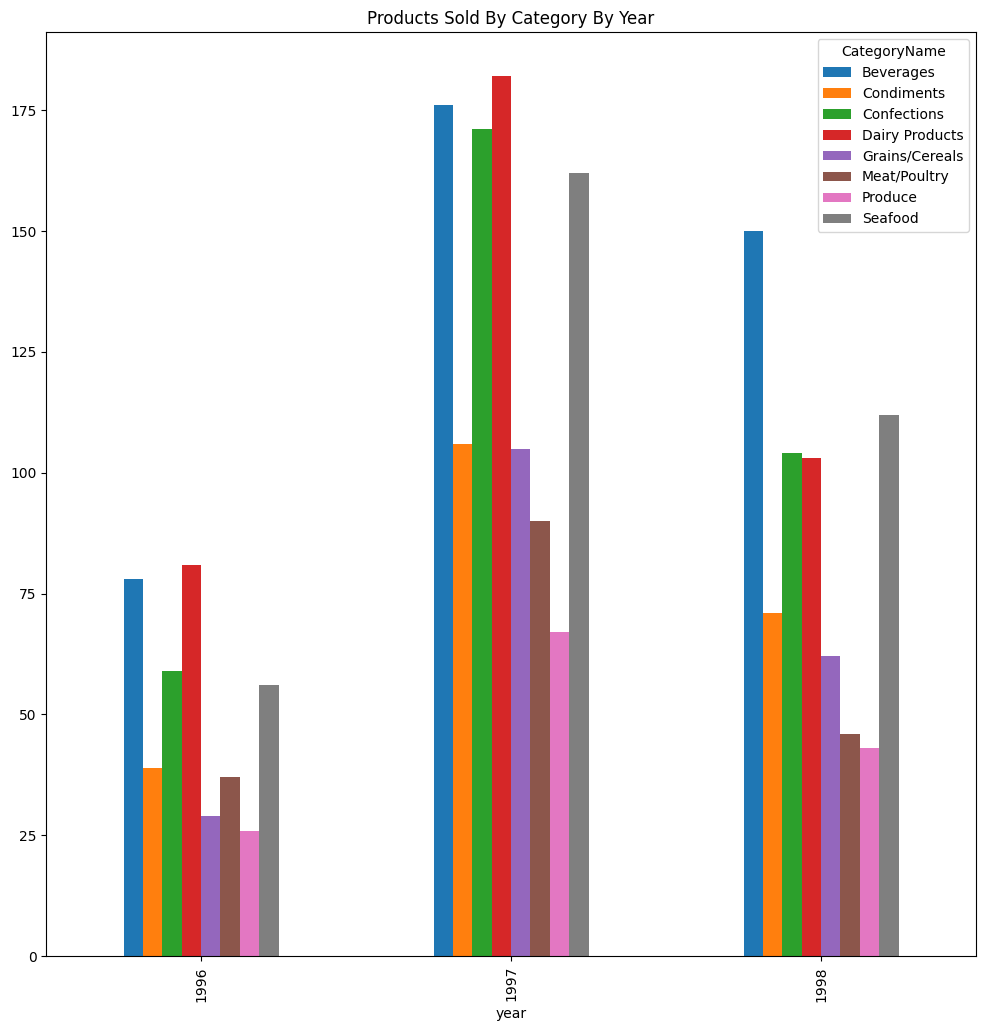

In [16]:
pd.pivot_table(products_sold_category_by_year, index = 'year', columns = 'CategoryName', values = 'num_sold').plot(kind = 'bar', legend=True, figsize=((12,12)), 
                                                                                                                   title = 'Products Sold By Category By Year')

## What if we want to drill down further?

In [17]:
products_sold_category_by_year_month = sqldf(
    """
    SELECT
        strftime('%Y-%m', o.OrderDate) as year_month,
        c.categoryname,
        COUNT(od.productid) as num_sold
    FROM orders o
    INNER JOIN order_details as od
        ON od.orderid = o.orderid
    INNER JOIN products p 
        ON od.productid = p.productid
    INNER JOIN categories c
     ON c.categoryid = p.categoryid
    GROUP BY
        1,2
    """
)

<Axes: xlabel='year_month'>

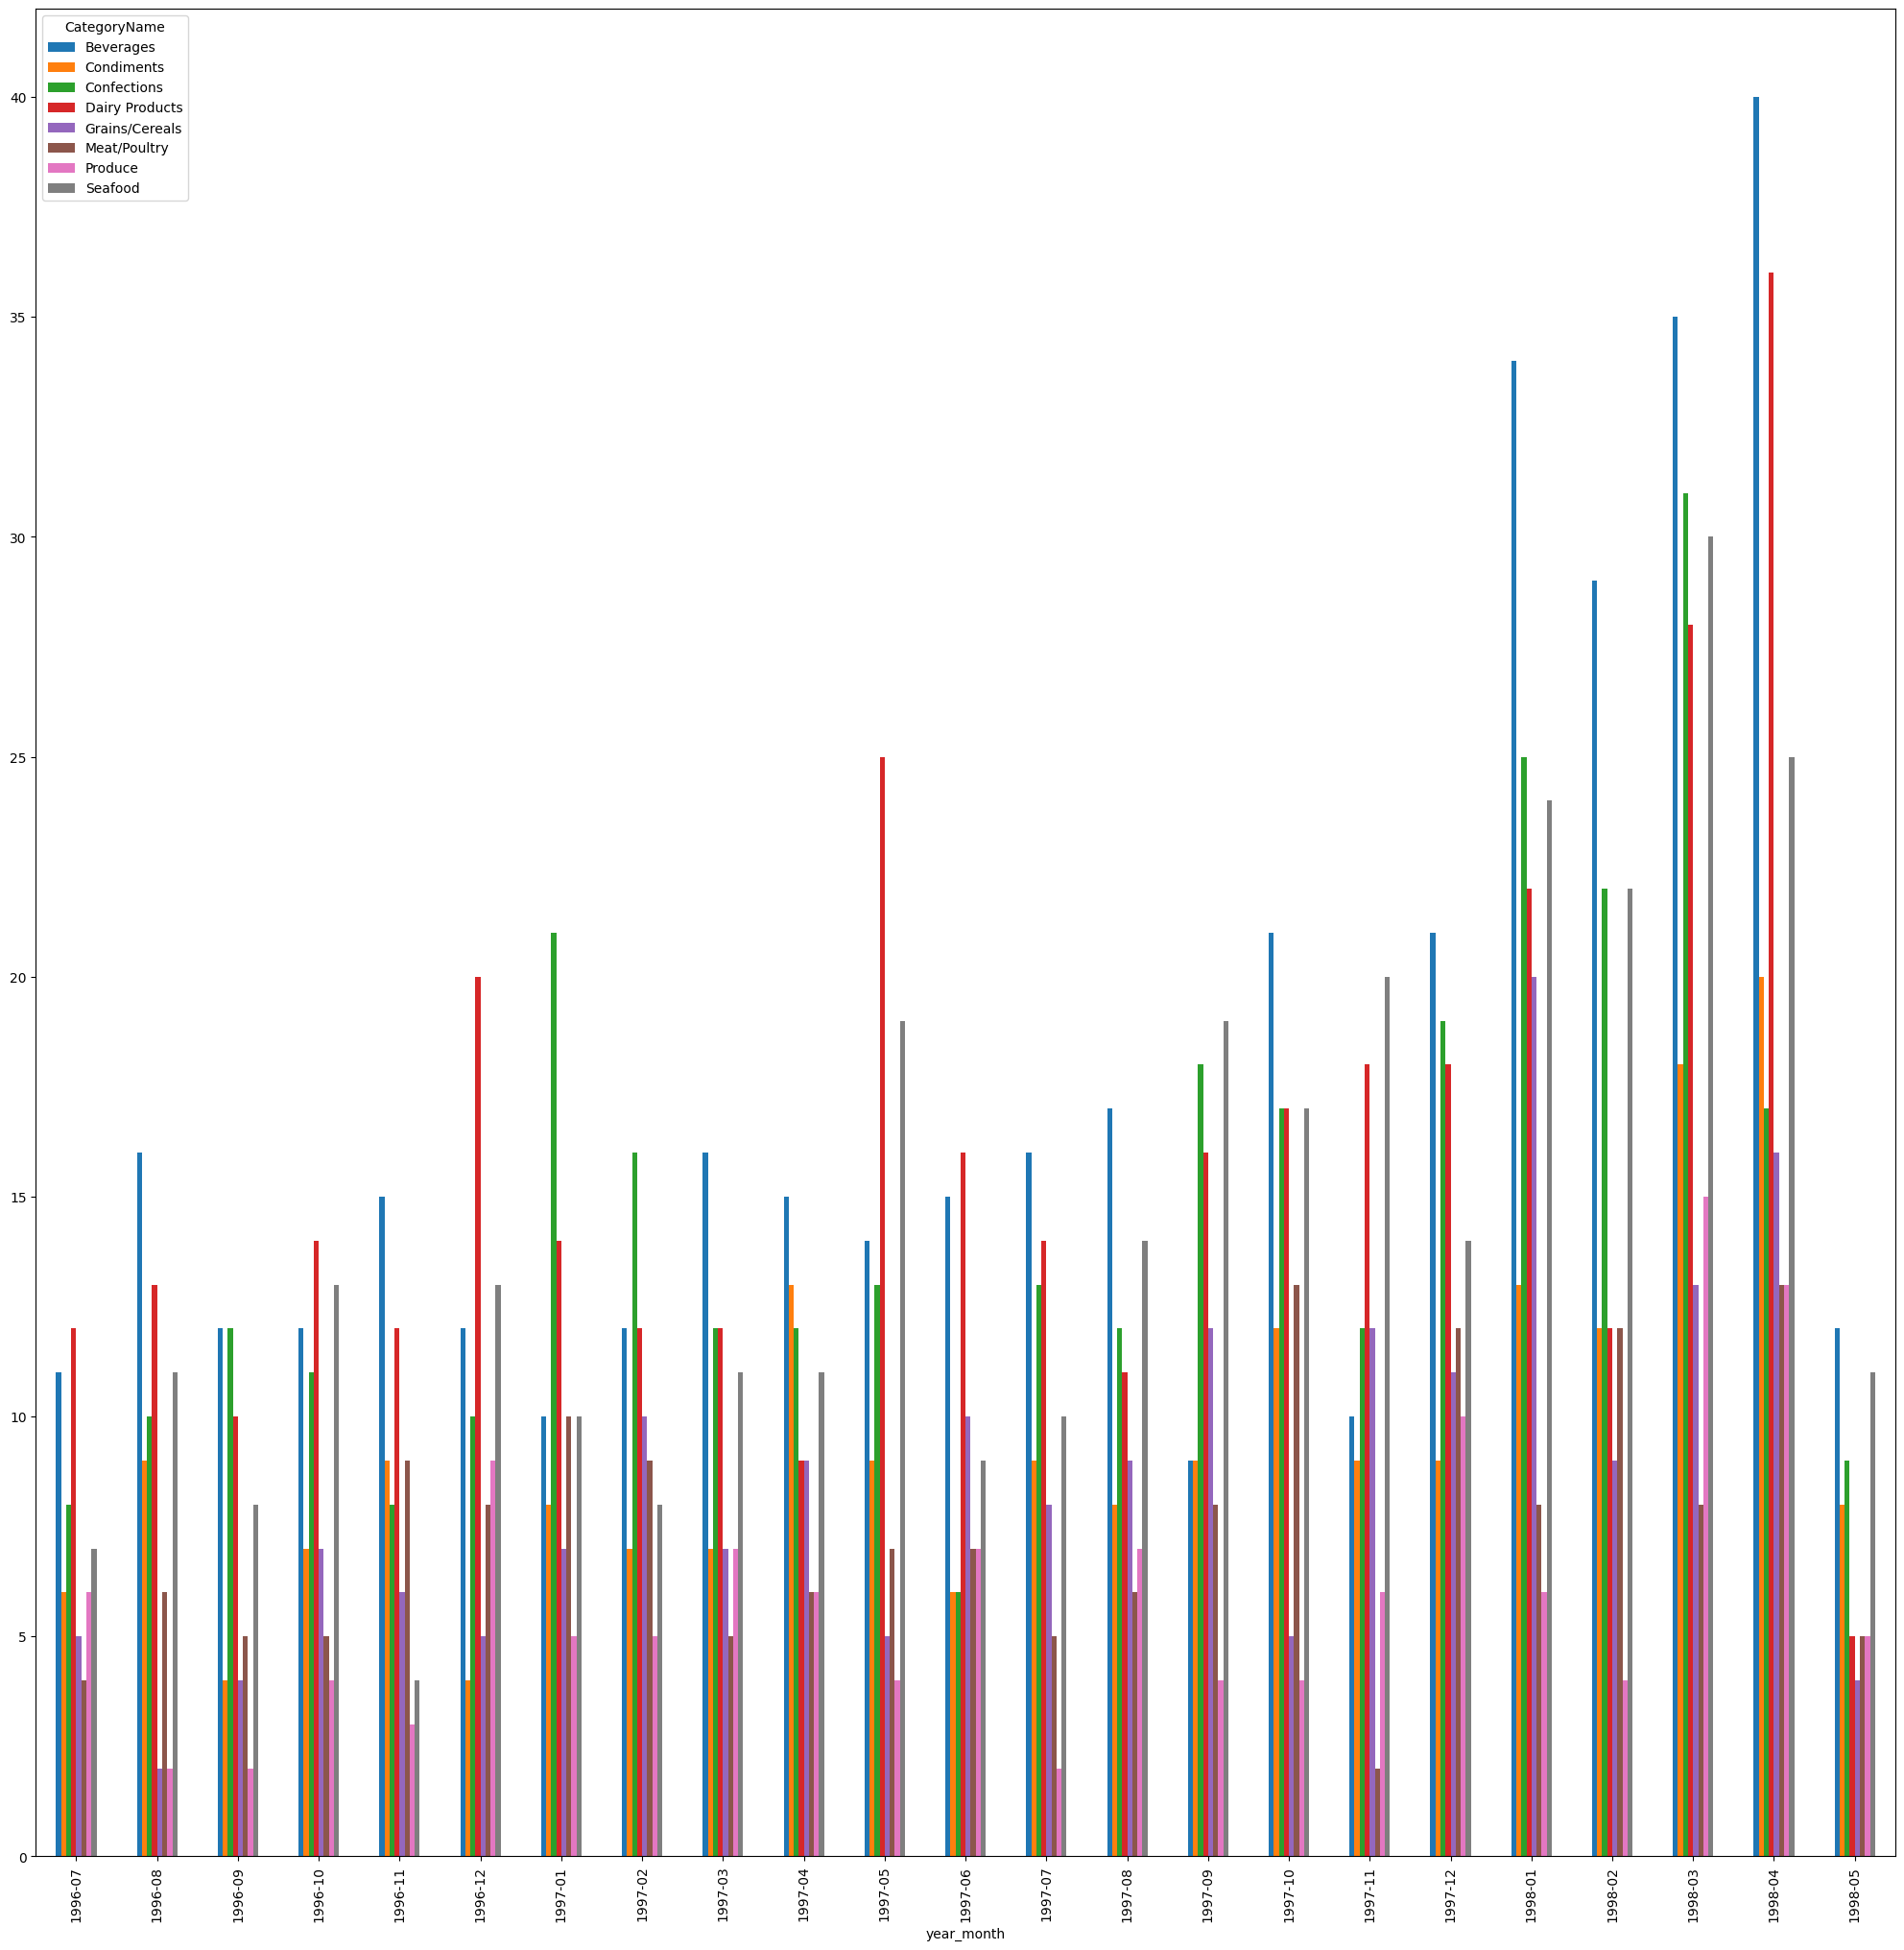

In [18]:
pd.pivot_table(products_sold_category_by_year_month, index = 'year_month', columns = 'CategoryName', values = 'num_sold').plot(kind = 'bar',legend=True, figsize=((25,25)), 
                                                                                                                    sharex = True)

All of the products Northwind sells by their category tend to have a steady increase and then all drop in 1998

# Customer Distribution

## Look at customers by country

C:\Users\ntlg4\AppData\Local\Temp\ipykernel_17932\1280260427.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  customer_country_plot.set_xticklabels(customer_country_plot.get_xticklabels(), rotation = 90)


[Text(0, 0, 'Argentina'),
 Text(1, 0, 'Austria'),
 Text(2, 0, 'Belgium'),
 Text(3, 0, 'Brazil'),
 Text(4, 0, 'Canada'),
 Text(5, 0, 'Denmark'),
 Text(6, 0, 'Finland'),
 Text(7, 0, 'France'),
 Text(8, 0, 'Germany'),
 Text(9, 0, 'Ireland'),
 Text(10, 0, 'Italy'),
 Text(11, 0, 'Mexico'),
 Text(12, 0, 'Norway'),
 Text(13, 0, 'Poland'),
 Text(14, 0, 'Portugal'),
 Text(15, 0, 'Spain'),
 Text(16, 0, 'Sweden'),
 Text(17, 0, 'Switzerland'),
 Text(18, 0, 'UK'),
 Text(19, 0, 'USA'),
 Text(20, 0, 'Venezuela')]

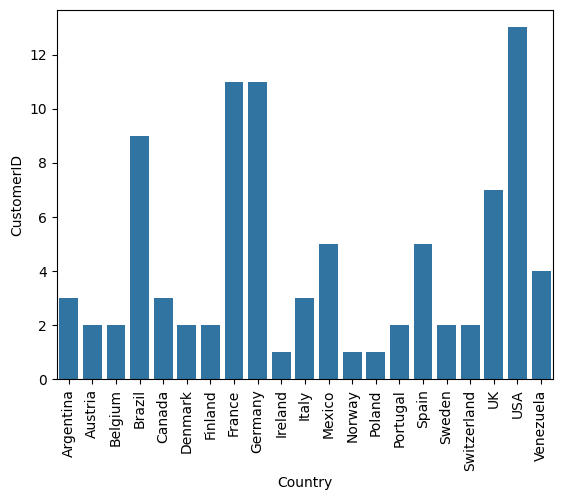

In [19]:
customer_country_plot = sns.barplot(x = 'Country', y = 'CustomerID', data = customers.groupby('Country')['CustomerID'].agg('count').reset_index())
customer_country_plot.set_xticklabels(customer_country_plot.get_xticklabels(), rotation = 90)

Looks like most of the customers are from the U.S. This is followed by Germany and France

# Look at Order Details

In [20]:
order_details.head()

,OrderID,ProductID,UnitPrice,Quantity,Discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


Since many products can be in an order, let's get the totals by order ID

In [31]:
 order_totals = sqldf(
    """
    SELECT
        orderid,
        ROUND(SUM(finaltotal),2) as ordertotal
    FROM(
    SELECT
        orderid,
        productid,
        unitprice,
        quantity,
        discount,
        unitprice * quantity AS subtotal,
        (unitprice * quantity) - ((unitprice * quantity) * discount) as finaltotal
    FROM
        order_details
    )
    GROUP BY
        orderid
    """
)

In [38]:
order_totals.head()

,orderid,ordertotal
0,10248,440.00
1,10249,1863.40
2,10250,1552.60
3,10251,654.06
4,10252,3597.90


Text(0.5, 1.0, 'Distribution of Orders')

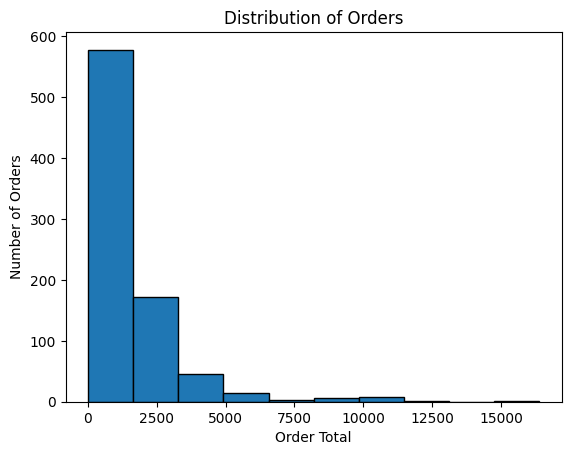

In [46]:
plt.hist(order_totals['ordertotal'], edgecolor = 'black')
plt.xlabel('Order Total')
plt.ylabel('Number of Orders')
plt.title('Distribution of Orders')

Looking at the distribution of orders, we see that is is positively skewed. A majority of the orders are less than $1250